<a href="https://colab.research.google.com/github/truongvanthanh95/Recommender-System-CDIO/blob/main/NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip --output data.zip
!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2527k      0 --:--:-- --:--:-- --:--:-- 2520k
Archive:  data.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
import pandas as pd
import numpy as np
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

In [ ]:
movie_tags = pd.crosstab(tags.movieId, tags.tag)
movieId_lookup = {}
movieId_inver_lookup = {}
for idx, movieId in enumerate(list(movie_tags.index)):
  movieId_lookup[movieId] = idx
  movieId_inver_lookup[idx] = movieId 
movie_vectors = movie_tags.to_numpy()
from sklearn.preprocessing import StandardScaler
movie_vectors = StandardScaler().fit_transform(movie_vectors)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
final_movie_vectors = pca.fit_transform(movie_vectors)
count_ratings = ratings.groupby('userId')['movieId'].count()

In [ ]:
userId = list(set(ratings.userId.values))
data = ratings.sample(frac=1, replace=False, random_state=200).reset_index(drop=True)
train_movies = {user: set() for user in userId}
train_input = {user: [] for user in userId}
train_output = {user: [] for user in userId}
test_input = {user: [] for user in userId}
test_output = {user: [] for user in userId}
test_movies = {user: set() for user in userId}
cnt_lk = {user: 0 for user in userId}
for t in data.values.tolist():
  curr_user = t[0]
  curr_movie = int(t[1])
  curr_ratings = t[2]
  if curr_movie not in movieId_lookup:
    continue
  if count_ratings[curr_user] <= 5:
    train_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
    train_output[curr_user].append(curr_ratings)
    train_movies[curr_user].add((curr_movie, curr_ratings))
  else:
    if cnt_lk[curr_user] < 0.8 * count_ratings[curr_user]:
      train_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
      train_output[curr_user].append(curr_ratings)
      train_movies[curr_user].add((curr_movie, curr_ratings))
      cnt_lk[curr_user] += 1
    else:
      test_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
      test_output[curr_user].append(curr_ratings)
      test_movies[curr_user].add((curr_movie, curr_ratings))

In [ ]:
num_user = len(userId)
num_movie = len(movieId_lookup)
movies_ncf = {}
movies_ncf_inver = {}
users_ncf = {}
users_ncf_inver = {}
tmp_idx = 0
for user in userId:
  users_ncf[user] = tmp_idx
  users_ncf_inver[tmp_idx] = user
  tmp_idx += 1
tmp_idx = 0
for movie in movieId_lookup:
  movies_ncf[movie] = tmp_idx
  movies_ncf_inver[tmp_idx] = movie
  tmp_idx += 1

In [ ]:
RELEVANT_THRESHOLD = 3.
MEAN_RATING = ratings.rating.mean()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
class NCFRecommender:
  def __init__(self, num_cluster = 1, num_neighbor = 10, metric="ball_tree"):
    self.utility_mat = np.zeros(shape=(num_user, num_movie))
    self.num_cluster = num_cluster
    self.num_neighbor = num_neighbor
    self.users_rating_count = {}
    self.metric = metric


  def fit(self, train_movies):
    for user in userId:
      self.users_rating_count[user] = 0
      for entry in train_movies[user]:
        self.utility_mat[users_ncf[user], movies_ncf[entry[0]]] = entry[1]
        self.users_rating_count[user] += 1

    kmeans = KMeans(n_clusters = self.num_cluster, random_state=0).fit(self.utility_mat)
    self.cluster_elements = [[] for _ in range(self.num_cluster)]
    self.cluster_element_vectors = [[] for _ in range(self.num_cluster)]
    self.cluster_lookup = {}
    self.cluster_inver_lookup = {}
    for idx, label in enumerate(kmeans.labels_):
      self.cluster_lookup[users_ncf_inver[idx]] = (label, len(self.cluster_elements[label]))
      self.cluster_inver_lookup[(label, len(self.cluster_elements[label]))] = users_ncf_inver[idx]
      self.cluster_elements[label].append(idx)
      self.cluster_element_vectors[label].append(np.array(self.utility_mat[idx]))

    self.cluster_neighbors = [NearestNeighbors(n_neighbors=self.num_neighbor + 5, algorithm=self.metric) for _ in range(self.num_cluster)]
    self.cluster_indices = []
    for cluster in range(self.num_cluster):
      # print(np.array(self.cluster_element_vectors[cluster]).shape)
      self.cluster_neighbors[cluster].fit(np.array(self.cluster_element_vectors[cluster]))
      
      distances, indices = self.cluster_neighbors[cluster].kneighbors(np.array(self.cluster_element_vectors[cluster]))
      self.cluster_indices.append(indices)
    users_total_rating = self.utility_mat.sum(axis = 1)
    users_total_count = self.utility_mat.astype('bool').sum(axis = 1)
    self.users_mean_rating = users_total_rating / users_total_count
  

  def predict(self, user, movie):
    curr_cluster = self.cluster_lookup[user][0]
    curr_idx = self.cluster_lookup[user][1]
    count_neighbor = 0
    total_rating = 0
    total_weight = 0
    best = []
    for elm in self.cluster_indices[curr_cluster][curr_idx]:
      if count_neighbor == self.num_neighbor:
        break
      nxt_user = self.cluster_inver_lookup[(curr_cluster, elm)]
      pearson = np.corrcoef(self.utility_mat[users_ncf[user]], self.utility_mat[users_ncf[nxt_user]])[0, 1]
      best.append((pearson, nxt_user, movie))
    best.sort(key=lambda x: abs(x[0]))
    best.reverse()
    for i in range(len(best)):
      nxt_user = best[i][1]
      pearson = best[i][0]
      movie = best[i][2]
      if self.utility_mat[users_ncf[nxt_user]][movies_ncf[movie]] != 0:
        total_rating += pearson * (self.utility_mat[users_ncf[nxt_user], movies_ncf[movie]] - self.users_mean_rating[users_ncf[nxt_user]])
        total_weight += abs(pearson)
        count_neighbor += 1
    predict_rating = self.users_mean_rating[users_ncf[user]]
    if total_weight > 0:
      predict_rating = self.users_mean_rating[users_ncf[user]] + total_rating / total_weight
    if predict_rating > 5:
      predict_rating = 5
    if predict_rating <= 0:
      predict_rating = 0.5
    return predict_rating
  
  def rmse(self, test_movies):
    curr_rmse = 0
    count_total = 0
    for user in userId:
      if len(test_movies[user]) > 0:
        count_total += len(test_movies[user])
        for entry in test_movies[user]:
          curr_movie = entry[0]
          curr_rating = entry[1]
          predict_rating = self.predict(user, curr_movie)

          curr_rmse += (predict_rating - curr_rating) ** 2
          # print(predict_rating, curr_rating, curr_rmse)
    return np.sqrt(curr_rmse / count_total)
  
  def ap10(self, user, train_movies, test_movies):
    if len(test_movies[user]) > 0:
      count_relevant = 0
      relevant_set = set()
      for elm in test_movies[user]:
        if elm[1] >= RELEVANT_THRESHOLD:
          relevant_set.add(elm[0])
          count_relevant += 1
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(self.predict(user, movie))
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      precision = 0
      rank = 0
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        if movies_ncf_inver[idx] in relevant_set:
          rank += 1
        count_rec += 1
        precision += rank / count_rec
      if len(relevant_set) > 0:
        return precision / len(relevant_set)
    return 0

  def hitrate_user(self, user, train_movies, test_movies):
    hit = 0
    if len(test_movies[user]) > 0:
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      goal_movies = set()
      for elm in test_movies[user]:
        goal_movies.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(self.predict(user, movie))
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      rank = 0
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        rank += 1
        if movies_ncf_inver[idx] in goal_movies:
          hit += 1 / rank
    return hit
  

  def map10(self, train_movies, test_movies):
    map = 0
    for user in userId:
      map += self.ap10(user, train_movies, test_movies)
    return map / len(userId)
  

  def hitrate(self, train_movies, test_movies):
    mhit = 0
    for user in userId:
      mhit += self.hitrate_user(user, train_movies, test_movies)
    return mhit / len(userId)

In [ ]:
rmse = []
map10 = []
hitrate = []
num_neighbors = [1, 5, 10, 15, 20]
for num_neighbor in num_neighbors:
  model = NCFRecommender(num_neighbor=num_neighbor)
  model.fit(train_movies)
  rmse.append(model.rmse(test_movies))
  map10.append(model.map10(train_movies, test_movies))
  hitrate.append(model.hitrate(train_movies, test_movies))
print(rmse)

[0.9125255040926731, 0.9027965368404617, 0.9066345370421769, 0.9135186839588965, 0.9204652110239165]


Text(0, 0.5, 'rmse')

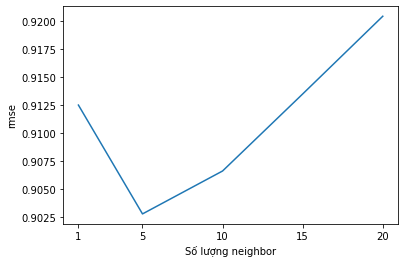

In [ ]:
num_neighbors = [1, 5, 10, 15, 20]
import matplotlib.pyplot as plt
plt.plot(num_neighbors, rmse)
plt.xlabel("Số lượng neighbor")
plt.xticks(num_neighbors)
plt.ylabel("rmse")

Text(0, 0.5, 'map10')

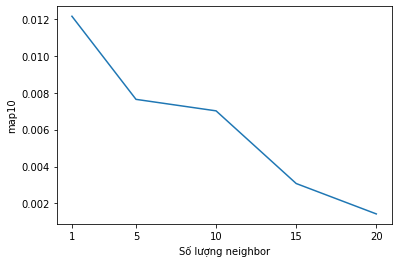

In [ ]:
plt.plot(num_neighbors, map10)
plt.xlabel("Số lượng neighbor")
plt.xticks(num_neighbors)
plt.ylabel("map10")

Text(0, 0.5, 'hitrate')

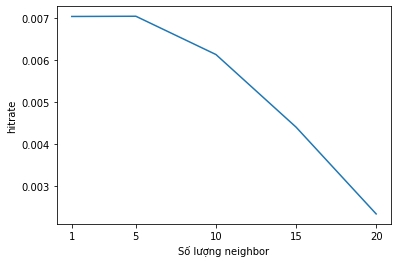

In [ ]:
plt.plot(num_neighbors, hitrate)
plt.xlabel("Số lượng neighbor")
plt.xticks(num_neighbors)
plt.ylabel("hitrate")

In [ ]:
rmse = []
map10 = []
hitrate = []
for num_cluster in range(1, 5):
  model = NCFRecommender(num_neighbor=5, num_cluster=num_cluster)
  model.fit(train_movies)
  rmse.append(model.rmse(test_movies))
  map10.append(model.map10(train_movies, test_movies))
  hitrate.append(model.hitrate(train_movies, test_movies))

In [ ]:
model = NCFRecommender(num_neighbor=5, num_cluster=5)
model.fit(train_movies)
rmse.append(model.rmse(test_movies))
map10.append(model.map10(train_movies, test_movies))
hitrate.append(model.hitrate(train_movies, test_movies))

ValueError: ignored

Text(0, 0.5, 'rmse')

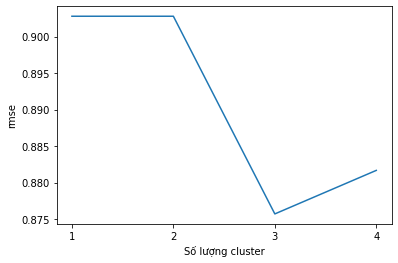

In [ ]:
num_clusters = list(range(1, 5))
import matplotlib.pyplot as plt
plt.plot(num_clusters, rmse)
plt.xlabel("Số lượng cluster")
plt.xticks(num_clusters)
plt.ylabel("rmse")

Text(0, 0.5, 'map10')

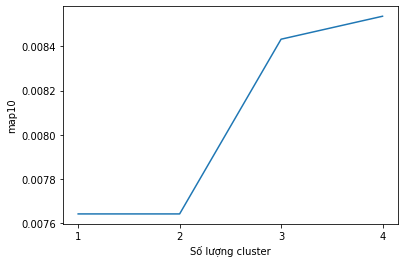

In [ ]:
plt.plot(num_clusters, map10)
plt.xlabel("Số lượng cluster")
plt.xticks(num_clusters)
plt.ylabel("map10")

Text(0, 0.5, 'hitrate')

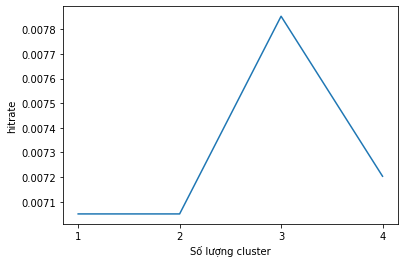

In [ ]:
plt.plot(num_clusters, hitrate)
plt.xlabel("Số lượng cluster")
plt.xticks(num_clusters)
plt.ylabel("hitrate")

In [ ]:
model.predict(1, 3)